### The Dataset is stored in the ```dataset``` folder 
downloaded from ```https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [59]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3
conda 4.9.0
wordcloud 1.8.0
"""
import configparser
import math
import datetime
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re

"""
Which dataset to use:
1 = IMDB
2 = Sentiment140
"""

DATASET = 1



############ SENTIMENT MODEL TRAINING PARAMETERS ################################
DIMENSION = 300
LEARNING_RATE = 1e-5
BATCH_SIZE = 128
EPOCHS = 20
#################################################################################


############ DATA SPLIT PERCENTAGE ##############################################
TRAINING_SPLIT = 0.80
#################################################################################


############ DATAFILE IS DOWNLOADED (for fresh download set this to False) ######
DATASET_DOWNLOADED = True
#################################################################################


############ NEED TO LIMIT THIS TO 60000 TO ENABLE BUILDING OF DISTANCE MATRIX ##
USE_MAX_VOCABULARY_SIZE = False
MAX_VOCABULARY_SIZE = 50000
#################################################################################

In [61]:
config = configparser.ConfigParser()
config.read('config/main.conf')

if DATASET == 1:
    set_dataset = "imdb"
if DATASET == 2:
    set_dataset = "s140"

DATASET_URL = (config[set_dataset]['DATASET_URL'])
DATASET_TAR_FILE_NAME = config[set_dataset]['DATASET_TAR_FILE_NAME']
TAR_FILE_PATH = config[set_dataset]['TAR_FILE_PATH']
CLEAN_DATA_FILE_NAME = config[set_dataset]['CLEAN_DATA_FILE_NAME']

DATASET_FOLDER = config[set_dataset]['DATASET_FOLDER']
FOLDER_NAME = config[set_dataset]['FOLDER_NAME']
DATA_SET = config[set_dataset]['DATA_SET']

MODEL_SAVE_DIRECTORY = config[set_dataset]['MODEL_SAVE_DIRECTORY']
TRAINING_SAVE_DIRECTORY = config[set_dataset]['TRAINING_SAVE_DIRECTORY']
 

MODEL_SAVE_PATH = config[set_dataset]['MODEL_SAVE_PATH']
CHECKPOINT_PATH = config[set_dataset]['CHECKPOINT_PATH']
CHECKPOINT_DIR = config[set_dataset]['CHECKPOINT_DIR']

TRAINING_HISORTY_SAVE_PATH = config[set_dataset]['TRAINING_HISORTY_SAVE_PATH']

COUNTER_FITTED_VECTORS = config[set_dataset]['COUNTER_FITTED_VECTORS']
GLOVE_EMBEDDINGS = config[set_dataset]['GLOVE_EMBEDDINGS']

GLOVE_EMBEDDINGS_FILE = config[set_dataset]['GLOVE_EMBEDDINGS_FILE']
COUNTER_FITTED_EMBEDDINGS_FILE = config[set_dataset]['COUNTER_FITTED_EMBEDDINGS_FILE']
 



### Create the model save directory

In [3]:
if not os.path.exists(MODEL_SAVE_DIRECTORY):
    os.makedirs(MODEL_SAVE_DIRECTORY)
    
if not os.path.exists(TRAINING_SAVE_DIRECTORY):
    os.makedirs(TRAINING_SAVE_DIRECTORY)


# Download the dataset and extract contents to correct directories

In [21]:
from manny_train import file_download_extraction as fde


from_folder =""
to_folder = DATA_SET

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
elif DATASET == 1:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)
    
    directories_in_dataset_folder = fde.get_directory_name(DATASET_FOLDER)

    if len(directories_in_dataset_folder) == 1:
        from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
        fde.rename_folder(from_folder, to_folder)
    else:
        print("ERROR!")
        print(DATASET_FOLDER," folder has too many sub directories!")
        print("Make sure ", DATASET_FOLDER, " is empty before downloading fresh dataset file")
elif DATASET == 2:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_zip_file(TAR_FILE_PATH, DATASET_FOLDER)
    fde.rename_s140_file(DATASET_FOLDER)
    


If you want to download a fresh copy of the data set,
make sure the variable DATASET_DOWNLOADED is set to False


# Process dataset
### Read the dataset file and return a data frame and show the first 5 rows of the data frame

In [98]:
from manny_train import data_loading as process

data_frame = pd.DataFrame
if DATASET == 1:
    data_frame  = process.process_dataset_IMDB(DATA_SET)
elif DATASET == 2:
    data_frame = process.process_dataset_Sentiment140(DATA_SET)
else:
    print("Please specify which dataset you want to work with...")

data_frame.head()


sentiment                                               text
0         0  I found the documentary entitled Fast, Cheap, ...
1         0  This is an embarrassment to everyone and every...
2         0  The cast although nothing special, all do an O...
3         0  Investigative reporter Darren McGavin (as Carl...
4         0  This movie is horrible. Everything in it has b...

## Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

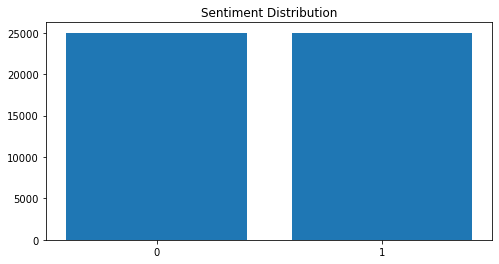

In [99]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution")

## Clean dataset: remove hyperlinks, html entities, punctuation and newline characters ...

In [100]:
from manny_train import clean_text_data as ctd

data_frame = ctd.clean_and_return(data_frame, "text")


Cleaning dataset, please wait ...
Dataset cleaned!


In [101]:
# save the cleaned dataset
data_frame.to_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME, index = False)
data_frame.shape

(50000, 2)

## Load saved data_frame 

In [4]:
# load the clean dataset from .csv file
dtypes = {'sentiment': 'str', 'text': 'str'}
data_frame = pd.read_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME) # make sure we import both columns as str


# clean data file
data_frame.head()



sentiment                                               text
0          0  i found the documentary entitled fast  cheap  ...
1          0  this is an embarrassment to everyone and every...
2          0  the cast although nothing special  all do an o...
3          0  investigative reporter darren mcgavin as carl ...
4          0  this movie is horrible  everything in it has b...

## Wordcloud of ```positive``` sentiments

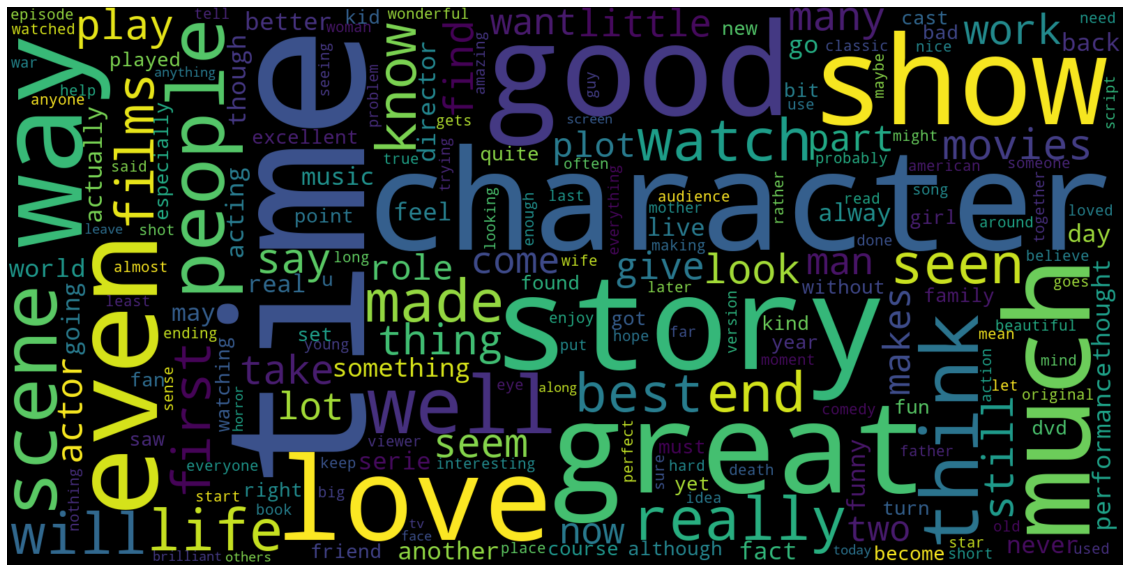

In [155]:
# add aditional stopwords
STOPWORDS.add("film")
STOPWORDS.add("movie")
STOPWORDS.add("one")
STOPWORDS.add("see")
STOPWORDS.add("make")

plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Wordcloud of ```negative``` sentiments

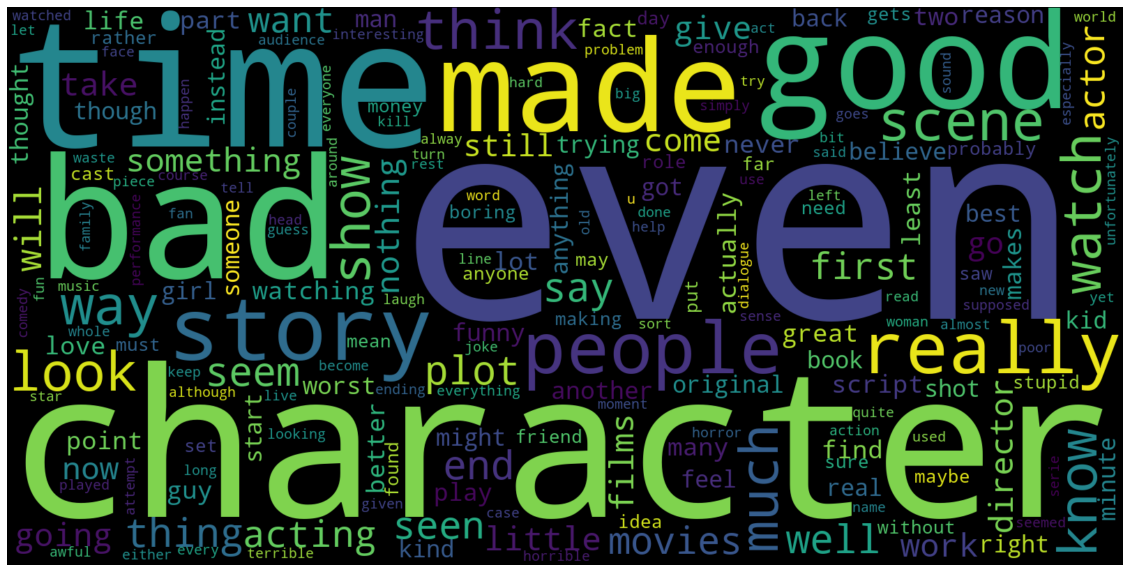

In [156]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Now we need to randomise the dataset

In [5]:

data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 


In [6]:
data_frame.head()


sentiment                                               text
29430          1  this is a delightful movie that is so overthet...
27750          1  after  i watched the films  i thought  why the...
47782          1  this short deals with a severely critical writ...
10498          0  just cause is one of those films that at first...
24747          0  for reasons i cannot begin to fathom  dr  lore...

## Now we split the data set into ```TRAINING_SPLIT``` for training and ```(1 - TRAINING_SPLIT)``` for testing
#### This will also shuffle the data set before splitting it

In [7]:

train_data, test_data = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)



In [8]:
print("Training Data:\t",len(train_data), " data points\t", math.ceil(TRAINING_SPLIT * 100),"%")
print("Test Data:\t",len(test_data), " data points\t", math.ceil((1 - TRAINING_SPLIT) * 100) ,"%")


Training Data:	 40000  data points	 80 %
Test Data:	 10000  data points	 20 %


## Examine the training and test data sets

### Training dataset

In [9]:
print("Number of data points: ",len(train_data))
train_data.head()

Number of data points:  40000


sentiment                                               text
25752          1  ingrid bergman is a temporarily impoverished p...
45064          1  meryl streep as kate  a woman dying of cancer ...
42924          1  twins effect  starring some of hk's most popul...
10658          0  no matter how well meaning his message is  thi...
32321          1  my wife and i have watched this movie twice  b...

### Testing dataset

In [10]:
print("Number of data points: ",len(test_data))
test_data.head()

Number of data points:  10000


sentiment                                               text
36359          1  at first  i hadn't read the novel so far and i...
9729           0  the fact that this movie has been entitled to ...
15270          0  this movie would receive a much higher vote fr...
40015          1  i had no expectations never saw previews for m...
41391          1  this is an excellent movie that tackles the is...

# Tokenization of training data
- We will use the new ```TextVectorization``` Keras class to tokenize our training data
- ```max_tokens``` i.e. limit vocabulary to this size 
- ```output_sequence_length``` i.e. limit length of text sequence

<center>
<img src="images/tokenization-manning.png">
</center>
  
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


#### We will use ```TextVectorization``` to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

#### Our layer will only consider the top $ 50,000 $ words, and will truncate or pad sequences to be actually $ 300 $ tokens long.

In [19]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # in Tensorflow 2.1 and above


vectorizer = TextVectorization(max_tokens=50000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(train_data.text).batch(128)
vectorizer.adapt(text_ds)


#### The top 5 words:

In [20]:

vectorizer.get_vocabulary()[:5]


[b'the', b'and', b'a', b'of', b'to']

#### Example vectorized sentence:

In [21]:
output = vectorizer([['the cow jumped over the moon']])
output.numpy()[0, :6]


array([   2, 6465, 4891,  126,    2, 1729])

## Create a dictionary, mapping words to their indices

In [22]:

vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))


In [23]:

test = [b"the", b"cat", b"sat", b"on", b"the", b"mat"]
[word_index[w] for w in test]


[0, 1211, 1739, 18, 0, 13906]

## Load pre-trained word GloVe embeddings

#### Create a dict mapping words (strings) to their NumPy vector representation

In [24]:

embeddings_index= {}
print("Loading embeddings model to dictionary, please wait...")
with open(GLOVE_EMBEDDINGS, 'r', encoding="utf8") as f:
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Finished!")
print('Found %s word vectors in model.' %len(embeddings_index))


Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.


#### Now prepare a corresponding embedding matrix that we can use in a Keras ```Embedding``` layer

In [25]:
print(len(vocabulary))

49999


In [26]:
num_tokens = len(vocabulary) + 2
embedding_dim = 300
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
count = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word.decode()) 
    if embedding_vector is not None:
        
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print("Embedding matrix shape: ",  (embedding_matrix.shape))

Converted 44411 words (5588 misses)
Embedding matrix shape:  (50001, 300)


#### Now we need to load the pre-traiined GloVe embeddings inot an ```Embedding``` layer
##### (We set ```training=False``` so to keep the embeddings fixed i.e. we do NOT want them to update during training)

In [27]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)


## Build our model

In [30]:

def create_model():
    # activation changed from tanh to relu
    # make sure to add the shape parameter (the length of the sequences), otherwise the loss and val_loss wont be calculated and will show as NaN
    sequence_input = keras.Input(shape=(300,), dtype='int64')
    embedding_sequences = embedding_layer(sequence_input)

    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(128, dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # set dropout rate to 0.5 to prevent over-fitting
    x = Dense(512, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid')(x)
    model =  keras.Model(sequence_input, predictions)

    # default learning rate is 0.001 for Adam optimizer
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["acc"]
    )
    return model

model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          15000300  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

## Train our model

#### Convert our list of strings data to a NumPy arrays of integer indices (arrays are right padded)

In [36]:
x_train = vectorizer(np.array([[s] for s in train_data.text])).numpy()
x_test = vectorizer(np.array([[s] for s in test_data.text])).numpy() # use this data to evaluate the model

y_train = np.array(train_data.sentiment)
y_test = np.array(test_data.sentiment) # used to evaluate the model

In [37]:
# make sure we have no null/NaN values in our data
train_data.isnull().any() 


sentiment    False
text         False
dtype: bool

#### We will use ```binary_crossentropy``` since we have only two possible classifications

In [38]:


# callbacks
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_lr = 0.0001, mode='min')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True,
                                                         verbose=1)


print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

hist = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test),callbacks=[reduce_lr_on_plateau,checkpoint_callback] )

print("\nFinished building model!")


../models/checkpoints/cp.ckpt
../models/checkpoints
Training on GPU...
Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 0.6925 - acc: 0.5148
Epoch 00001: saving model to ../models/checkpoints/cp.ckpt
313/313 [==============================] - 30s 97ms/step - loss: 0.6925 - acc: 0.5148 - val_loss: 0.6878 - val_acc: 0.5455 - lr: 1.0000e-04
Epoch 2/30
312/313 [============================>.] - ETA: 0s - loss: 0.6640 - acc: 0.5978
Epoch 00002: saving model to ../models/checkpoints/cp.ckpt
313/313 [==============================] - 29s 93ms/step - loss: 0.6640 - acc: 0.5979 - val_loss: 0.6495 - val_acc: 0.6243 - lr: 1.0000e-04
Epoch 3/30
312/313 [============================>.] - ETA: 0s - loss: 0.6286 - acc: 0.6492
Epoch 00003: saving model to ../models/checkpoints/cp.ckpt
313/313 [==============================] - 29s 94ms/step - loss: 0.6287 - acc: 0.6492 - val_loss: 0.5858 - val_acc: 0.6927 - lr: 1.0000e-04
Epoch 4/30
312/313 [============================>.] - ETA: 

In [64]:
!ls {CHECKPOINT_DIR}

checkpoint		     cp.ckpt.data-00001-of-00002
cp.ckpt.data-00000-of-00002  cp.ckpt.index


## Evaluate model using unseen test data

In [58]:

scores_evaluate = model.evaluate(x_test,y_test,verbose=1, batch_size=128)
print("Accuracy: %.2f%%" % (scores_evaluate[1]*100))


79/79 [==============================] - 3s 40ms/step - loss: 0.3722 - acc: 0.8383
Accuracy: 83.83%


In [83]:
# recreate model and load weights
model = create_model()
model.load_weights(CHECKPOINT_PATH)


ValueError: in user code:

    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/keras/layers/convolutional.py:207 call
        outputs = self._convolution_op(inputs, self.kernel)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1106 __call__
        return self.conv_op(inp, filter)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:638 __call__
        return self.call(inp, filter)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:231 __call__
        return self.conv_op(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:220 _conv1d
        return conv1d(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1655 conv1d
        result = gen_nn_ops.conv2d(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py:965 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3319 _create_op_internal
        ret = Operation(
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1816 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/mas/anaconda3/envs/project-code/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node model_16/conv1d_14/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](model_16/conv1d_14/conv1d/ExpandDims, model_16/conv1d_14/conv1d/ExpandDims_1)' with input shapes: [?,1,1,300], [1,5,300,64].


## Export an end to end model
#### We want our model to take as input a string of arbitrary length, rather than a sequence of indices. So that we have a more portable model, since you wouldn't have to worry about the input preprocessing pipeline.

Our vectorizer is actually a Keras layer, so it's simple:

In [82]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)

preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

# predict unseen negative review for the new Mandalorian TV show (4 star rating)
t_neg = [["John Leguizemo, a wonderful comic actor, is a New York Latino, able to get inside a myriad of characters, both male and female, to show the bizarre foibles of an ethnic group trying to cope in an alien culture. He is not, however, Italian. He doesn't look, think or behave Italian...Especially Sicilian or Calabrese, immigrant groups who live in Bensonhurst or Bayridge Brooklyn. Every scene in which he interacts with his 'Gumbas' rings false, as though he'd wandered in from a college production of 'West Side Story' while the other guys were doing a low-rent 'Mean Streets'. That's only one problem with this ill-conceived, mean-spirited flick."]]
prob_negative = end_to_end_model.predict(t_neg)
print("Predicted prob for negative review on unseen data: ", prob_negative)

# predict unseen positive review for the new Mandalorian TV show (9 star rating)
t_pos = [["This is the Star Wars atmosphere and feeling I've been waiting for. No dumb humor, cool characters, and a story I can take seriously. I'm a big fan of what they've done with this series so far and current Star Wars filmmakers need to take notes. The cinematography is amazing. You can tell they use practicality as much as possible and CGI is used only for the obvious like spaceships and creatures etc. It's a truly remarkable balance of old and new."]]
prob_positive = end_to_end_model.predict(t_pos)
print("Predicted prob for positive review on unseen data: ", prob_positive)

type(prob_positive)

Predicted prob for negative review on unseen data:  [[0.47831467]]
Predicted prob for positive review on unseen data:  [[0.5973398]]


numpy.ndarray

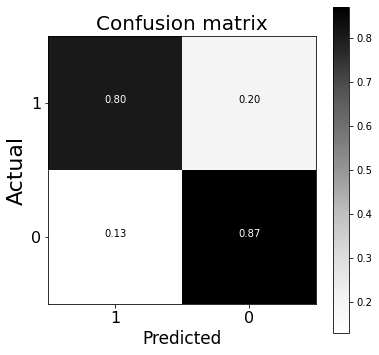

In [66]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys, normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)
    
    
def decode_sentiment(score):
    return 1 if score>0.5 else 0

scores_predict = model.predict(x_test,verbose=0, batch_size=128)
y_predictions = [decode_sentiment(score) for score in scores_predict]



cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.savefig('images/imdb-confusion-matrix.png',bbox_inches='tight')
plt.show()


In [67]:
print(classification_report(list(test_data.sentiment), y_predictions))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4938
           1       0.82      0.87      0.85      5062

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Save the model and training history

In [108]:
from tensorflow.keras.models import Sequential, save_model, load_model
import pickle



# save the model outside of git directory - so we don't try and push to github
# add code to check save directory exists, if not then create it
save_model(model, MODEL_SAVE_PATH)

# save history as a dictionary in case we need to plot again later
with open(TRAINING_HISORTY_SAVE_PATH, 'wb') as file_pickle:
        pickle.dump(hist.history, file_pickle)
       


## Delete model and end_to_end_model
#### To test they reload correctly

In [110]:
# tf.saved_model.save(end_to_end_model, END_TO_END_MODEL_SAVE_PATH)
save_model(end_to_end_model, END_TO_END_MODEL_SAVE_PATH)

# del end_to_end_model
# del model

INFO:tensorflow:Assets written to: ../models/imdb/final_model/assets


In [17]:
from tensorflow.keras.models import Sequential, save_model, load_model
import pickle

end_model = load_model(END_TO_END_MODEL_SAVE_PATH, compile=True)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7f85b1b26520> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7f85abd27c40>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7f85b1b26520> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7f85abd27c40>).


In [18]:
# t_pos = [["But it is kinda hilarious, at least if you grew up on Weird Al, like I did. It's a mockumentary about his life and career, beginning with superstardom and going back to trace the origins. It's uneven in places, but some of the segments are still very funny, particularly when he goes to Japan. Although it's not quite as emotionally textured as Lost in Translation, and he doesn't find love however fleeting, he does capture in a bottle the absolutely bizarre cultural melange that is Tokyo street life."]]
# prob_positive = end_model.predict(t_pos)
# print(prob_positive)
end_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 300)               0         
_________________________________________________________________
model (Model)                (None, 1)                 15688749  
Total params: 15,688,749
Trainable params: 15,688,749
Non-trainable params: 0
_________________________________________________________________


## Load saved model

In [75]:
import keras
from keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf


model = load_model(MODEL_SAVE_PATH, compile = True)
  
hist = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))
#end_to_end_model = load_model("/home/mas/models/end_model.tf")






In [86]:
saved_model = keras.models.load_model(END_TO_END_MODEL_SAVE_PATH)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7fc9f5dc6310> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7fc9f5dc6520>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7fc9f5dc6310> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7fc9f5dc6520>).


In [87]:
type(saved_model)

tensorflow.python.keras.engine.training.Model

In [92]:
y_predict = saved_model(tf.constant(t_pos, dtype=tf.string))
print(y_predict)

tf.Tensor([[0.04654495]], shape=(1, 1), dtype=float32)


In [38]:
# predict unseen negative review for the new Mandalorian TV show (4 star rating)
t_neg = [["I'm a starwars franchise fan, and a Jon Favreau fan. I truly had great expectations when i saw the trailer. I thought that, wow, finally a spin-off with this legendary Mandalorian. Well, i'm really disappointed to discover a well directed but very weak story line, full of clichés"]]
prob_negative = end_to_end_model.predict(t_neg)
print("Predicted prob for negative review on unseen data: ", prob_negative)

# predict unseen positive review for the new Mandalorian TV show (9 star rating)
t_pos = [["Finally, this feels like the Star Wars universe. The cinematography, the atmosphere, the story line, wow! My only negative is, the episodes are too short."]]
prob_positive = end_to_end_model.predict(t_pos)
print("Predicted prob for positive review on unseen data: ", prob_positive)



Predicted prob for negative review on unseen data:  [[0.6752411]]
Predicted prob for positive review on unseen data:  [[0.6752411]]


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [30]:

counter_embeddings_matrix = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)


max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [31]:

print(counter_embeddings_matrix.shape)


(60001, 300)


### Save our vocabulary embeddings matrix

In [33]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/"+COUNTER_FITTED_EMBEDDINGS_FILE
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/S140_counter_fitted_embeddings_60000.npy


# Save the model
we can later load it from disk

In [43]:
from keras.models import load_model
model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [44]:

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 300)          18000300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

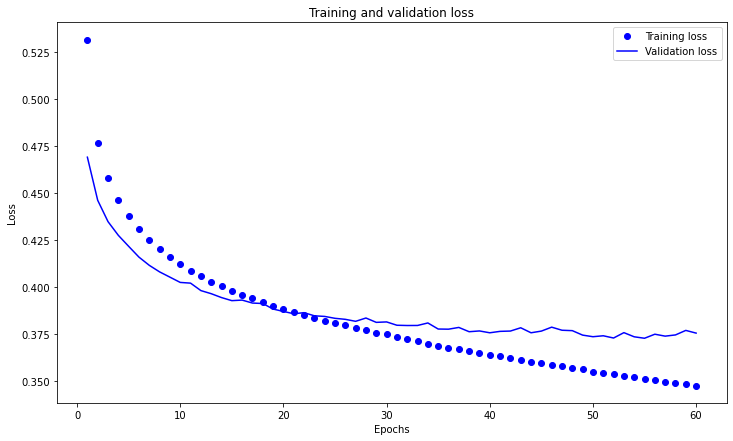

In [45]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/S140-training-and-validation-loss.png',bbox_inches='tight')
plt.show()


<Figure size 432x288 with 0 Axes>

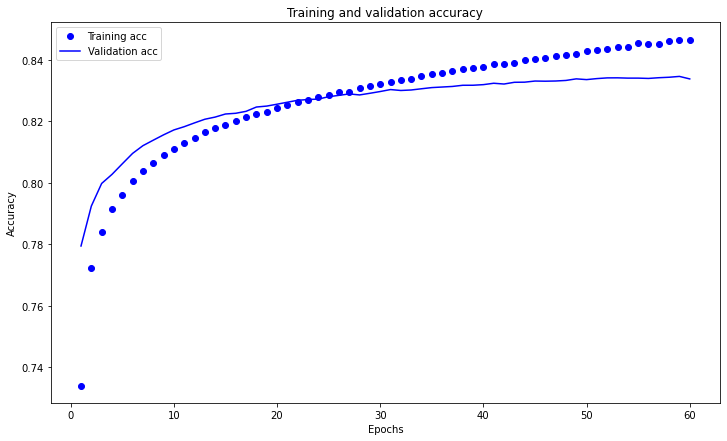

In [46]:
plt.clf()   # clear figure
plt.figure(figsize=(12,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/S140-training-and-validation-accuracy.png',bbox_inches='tight')
plt.show()


# At this point we have saved the clean dataset file, model and history of the training 
### Now we can just load the model, when we need it for generating adversarial examples against it

In [10]:
from keras.models import load_model
import pickle

model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [6]:
from keras.preprocessing.text import text_to_word_sequence
import nltk

# def Preparing_string(text_string):
        
#         if len(text_string.strip()) == 0:
#             return None
        
#         data = [text_string]
#         df = pd.DataFrame(data, columns = ['text']) 
#         text_string = ctd.clean_and_return(df,"text")
#         text_string = text_string.text[0]
     
       
#         word2index = word_index
#         test=[]
#         for word in text_to_word_sequence(text_string):
#             test.append(word2index.get(word,0))
    
#         print("SHAPE: ", type(word2index))
#         dimension = 2560
#         results = np.zeros(dimension)
#         for _ , sequence in enumerate(test):
#             if sequence < dimension:
#                 results[sequence] = 1
    
#         #print("\nOriginal string:", text_string,"\n")
#         #print("\nIndex conversion:", test,"\n")
#         results = np.reshape(results,(1, dimension))
#        # print("\nConvert to vectors:", results,"\n")

#         return results
    
def Preparing_string(text_string, dimension = 2560):
        text_string = text_string.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        text_string = text_string.translate(table)
    
        word2index = word_index
        test=[]
        for word in word_tokenize(text_string):
            test.append(word2index[word])
    
        results = np.zeros(dimension)
        for _ , sequence in enumerate(test):
            if sequence < dimension:
                results[sequence] = 1
    
        print("\nOriginal string:", text_string,"\n")
        print("\nIndex conversion:", test,"\n")
        results = np.reshape(results,(1, dimension))
        print("\nConvert to vectors:", results,"\n")
        return results






In [656]:
test_String = "I don't feel like I know the characters at all. I have no idea why the two soldiers were friends or what they had been through together. The cinematography tried so hard to make this an emotional shocking movie that it had the opposite effect. War scenes with gratuitous up close views of corpses and body parts that don't add anything to the story got old quick."

#test_prediction = Preparing_string(test_String)

print("Prediction: ",model.predict(Preparing_string(test_String, 10000)))


NameError: name 'word_tokenize' is not defined

In [360]:
print("DATA DICT: ", len(word_index))

DATA DICT:  262307


KeyError: 'reflectant'

In [49]:
counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)
#counter_dict = counter_embeddings_dictionary(COUNTER_FITTED_VECTORS)

max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


In [279]:
import numpy as np
counter_embeddings_matrix = np.load(("embeddings/imdb_counter_fitted_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))
#print(find_closest_embeddings(data_dictionary["movies"])[1:10])


print(type(counter_embeddings_matrix))
print(counter_embeddings_matrix.shape)

<class 'numpy.ndarray'>
(60001, 300)


60001


113

# Generate and save word distance matrix
#### l2 distance: $(x-y)^2$ expand this out and we get: $x^2 + y^2 - 2xy$ using this to calculate euclidian (l2) distance between vectors



In [162]:
def distance_matrix(matrix):
    dists = -2 * np.dot(matrix, matrix.T) + np.sum(matrix**2,    axis=1) + np.sum(matrix**2, axis=1)[:, np.newaxis]
    return dists

In [60]:
"""
THIS IS WHY WE HAVE TO REDUCE THE VOCABULARY SIZE - WE NEED TO ALLOCATE ENOUGH SPACE FOR THIS MATRIX
IF WE USE THE FULL VOCABULARY SIZE - WE WILL NOT BE ABLE TO ALLOCATE ENOUGH MEMORY FOR THE SIZE OF THE MATRIX
THAT WILL BE GENERATED
"""
square_matrix = -2 * np.dot(counter_embeddings_matrix, counter_embeddings_matrix.T)
print(len(square_matrix))

60001


In [61]:
a = np.sum(np.square(counter_embeddings_matrix), axis=1).reshape((1,-1))

In [62]:
b = a.T

In [63]:
square_matrix.shape

(60001, 60001)

In [64]:
a.shape

(1, 60001)

In [65]:
b.shape

(60001, 1)

# Save the distance matrix

In [66]:
dist = a + b + square_matrix

In [67]:
np.save(('embeddings/distance_counterfitted_embeddings_%d.npy' % MAX_VOCABULARY_SIZE), dist)

In [90]:
np.amax(dist)

2.859412738646227

In [92]:
np.amin(dist)

-8.881784197001252e-16

# Closest words in disrtance matrix, and their distances

In [91]:
from manny_train import build_embeddings as bemb

for r in range(100,105):
    source_word = r
    
    nearest_neighbour, distance_to_neighbour = bemb.closest_neighbours(source_word, dist, ret_count=5)
    
    print("Nearest Neighbours to `%s` are:" %inv_data_dictionary[source_word])
    
    for word_index, distance in zip(nearest_neighbour,distance_to_neighbour):
        print("\t--> ", inv_data_dictionary[word_index], "     ", distance)
    print("----------------------------------------------------------------\n")



Nearest Neighbours to `after` are:
	-->  subsequently       0.19739067975234348
	-->  afterward       0.21351224306351346
	-->  thereafter       0.21713814789663277
	-->  afterwards       0.22155526197445496
	-->  upon       0.23389274616020228
----------------------------------------------------------------

Nearest Neighbours to `think` are:
	-->  thought       0.15096381446318552
	-->  thoughts       0.19772474379935123
	-->  reckon       0.2158823221500985
	-->  thinks       0.25389518633056785
	-->  believe       0.27684226527503797
----------------------------------------------------------------

Nearest Neighbours to `characters` are:
	-->  personages       0.06438505936322758
	-->  character       0.07006674850581618
	-->  traits       0.11063837435466573
	-->  nature       0.17886766452615865
	-->  trait       0.21602845788842173
----------------------------------------------------------------

Nearest Neighbours to `watch` are:
	-->  surveillance       0.5249733280639659
	-->

In [71]:
dist_order = np.argsort(dist[src_word, :])[1:8]
print(dist_order)

[   19  1493   104    99   444 10300  1238]


# Load original IMDB reviews 
#### Load as text (byte strings), using Tensorflow Datasets

In [16]:
import tensorflow_datasets as tfds

In [19]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

Shuffling and writing examples to /home/mas/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR8GPOV/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/mas/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR8GPOV/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/mas/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR8GPOV/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/mas/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [369]:
print(datasets)

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}


# Preprocessing function
#### Use only tensorflow operations for preprocessing -  this will enable us to deploy to, for example, a mobile device without having to write a different preprocessing function every time

In [352]:
def preprocess_imdb(X_batch, y_batch):
  
    X_batch = tf.strings.substr(X_batch, 0, 300) # truncate reviews, keep first 300 chars to speed up training
    #X_batch = tf.strings.regex_replace(X_batch, rb"[^\x00-\x7F]","") # remove non printing chars
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ") # replace <br /> tags with space
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ") # replace any chars other than letters and quotes with spaces   
    X_batch = tf.strings.split(X_batch) # split reviews by spaces
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch # return padded tensor using <pad> as padding, ensure all tensors are same size

# Construct the vocabulary
#### We need to go through the whole training set once, apply the above ```preprocess_imdb``` function and use a Counter to count the number of occurances of each word

In [468]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(64).map(preprocess_imdb):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [469]:
X_batch.shape

TensorShape([40, 62])

# Remove non UTF-8 items

In [425]:
delete_vocab_items = []
for v in vocabulary:
    try:
        v.decode()
    except UnicodeDecodeError as e:
        delete_vocab_items.append(v)

for item in delete_vocab_items:
    del vocabulary[item]

        

[b'\xc2', b'Singin\xe2']
53891


# Most common 5 words

In [450]:
vocabulary.most_common()[:5]


40

# Set maximum vocabulary size to 10,000 words

In [427]:

truncated_vocabulary = [word for word, count in vocabulary.most_common()[:MAX_VOCABULARY_SIZE]]

In [428]:
#print(len(truncated_vocabulary))
truncated_vocabulary[34324].decode()

#bytes(line, 'utf-8').decode('utf-8','ignore')


'excreme'

# Replace each word with with its ID (i.e. its index in the vocabulary)
#### Create a lookup table for this using 1000 out-of-vocabulary (oov) buckets

In [429]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

## Lookup IDs of words from ```table```

In [430]:
table.lookup(tf.constant([b"I enjoyed this movie very MUUUUUUCHHHHHHHHHHHHH".split()]))

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[    6,   325,     9,    12,    43, 50325]])>

#### From the output we see that the words ```I```, ```enjoyed```, ```this```, ```movie``` and ```very``` were found in the in the table (i.e. their IDs are lower than 10,000). However the word ```MUUUUUUCHHHHHHHHHHHHH``` was not found, so it is mapped to one of the $ oov $ buckets, with an ID greater than or equal to 10,000

# Create final training set
### The steps involved are:
#### 1)  batch the reviews
#### 2) convert them to short sequences of words using our ```preprocess_imdb()``` function
#### 3) encode these words using the ```encode_words()``` function (this function uses the ```table``` we just created above
#### 4) pre-fetch the next batch

In [431]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [432]:
train_set = datasets["train"].batch(32).map(preprocess_imdb) # batch the reviews and convert to short sequences
train_set = train_set.map(encode_words).prefetch(1) # encode words and prefetch batch

# Load GloVe Embeddings index


In [362]:
embeddings_index= {}
print("Loading embeddings model to dictionary, please wait...")
with open(GLOVE_EMBEDDINGS, 'r', encoding="utf8") as f:
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Finished!")
print('Found %s word vectors in model.' %len(embeddings_index))

Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.


## We now need an embedding matrix that we can use in a Keras Embedding layer. This is simply NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [437]:

    
num_tokens = MAX_VOCABULARY_SIZE + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
count = 0
for i, word in enumerate(truncated_vocabulary):
    count += 1

    embedding_vector = embeddings_index.get(word.decode())
    
    if embedding_vector is not None:
        
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

# max_vocabulary_size = len(truncated_vocabulary) + 1

    
# print("\nCreating embeddings matrix ...")
# embedding_matrix = np.zeros((max_vocabulary_size, 300)) 
    
# for i, word in enumerate(truncated_vocabulary):
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector
# print("Finished!")        
# print(embedding_matrix.shape)

Converted 43531 words (6469 misses)
(50002, 300)


# Create and train the model

In [475]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

embedding_layer = tf.keras.layers.Embedding(
            input_dim = num_tokens + num_oov_buckets,
            output_dim = 300,
            weights = embedding_matrix,
            input_length= 300, # length of sequence
            trainable=False
        )

embed_size = 300

model = keras.models.Sequential([
    keras.layers.Embedding(MAX_VOCABULARY_SIZE , embed_size, weights=embedding_matrix),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.Conv1D(64, 5, activation='tanh'),
    keras.layers.Bidirectional(LSTM(128, dropout=0.2)),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
    
])



ValueError: You called `set_weights(weights)` on layer "embedding_19" with a weight list of length 50002, but the layer was expecting 1 weights. Provided weights: [[ 0.          0.          0.         ...  0.     ...

In [103]:
print(type(table))

<class 'tensorflow.python.ops.lookup_ops.StaticVocabularyTable'>


In [ ]:
print(word)

In [117]:
for word, i in vocabulary.items():
    print("word: ", word," i: ", i)
    break

word:  b'This'  i:  6672


In [170]:
truncated_vocabulary[34302].decode('unicode')

LookupError: unknown encoding: unicode

In [225]:
import sys
sys.getdefaultencoding()

'utf-8'